# Hugging Face 라이브러리를 사용해서 뉴스 기사 분류 모델 만들기
- fancyzhx/ag_news 라는 뉴스 기사 데이터셋을 사용
- distilbert 와 openai-gpt 모델을 fine-tuning 해서 뉴스 기사 분류 모델을 만들어 보기
- 다음의 과정을 진행한다.
    1. pre-trained 모델과 그 모델의 tokenizer 불러오기
    2. 데이터셋을 그 tokenizer 로 전처리하기
    3. 데이터셋을 train 과 validation 으로 나누기
    4. TrainingArguments 와 Trainer 를 사용해서 학습하기
    5. 학습한 모델 평가하기

## AG News 데이터셋 불러오기
- 4개의 뉴스 카테고리
    - 1: World, 2: Sports, 3: Business, 4: Science/Technology

In [2]:
from datasets import load_dataset

ds_ag_news = load_dataset("fancyzhx/ag_news")
ds_ag_news

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [3]:
NUM_AG_NEWS_LABELS = 4

ag_news_id2label = {0: "WORLD", 1: "SPORTS", 2: "BUSINESS", 3: "SCIENCE_AND_TECHNOLOGY"}

ag_news_label2id = {"WORLD": 0, "SPORTS": 1, "BUSINESS": 2, "SCIENCE_AND_TECHNOLOGY": 3}

## DistilBERT 모델 기반의 분류 모델 정의하기
- AutoModelForSequenceClassification 사용
    - num_labels 은 데이터셋의 클래스 개수로 설정
    - id2label 과 label2id 는 데이터셋의 클래스 이름으로 설정


In [4]:
from transformers import AutoModelForSequenceClassification

classifier_b = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-cased",
    num_labels=NUM_AG_NEWS_LABELS,
    id2label=ag_news_id2label,
    label2id=ag_news_label2id,
)
classifier_b

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [5]:
# distilbert 모델의 모든 레이어들을 freeze
for param in classifier_b.distilbert.parameters():
    param.requires_grad = False

## BERT Tokenizer 로 데이터셋 전처리하기

In [6]:
from transformers import AutoTokenizer

distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/Users/joyuiyeong/.pyenv/versions/3.11.9/envs/deeplearning/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
def bert_preprocess_function(data):
    return distilbert_tokenizer(data["text"])


distilbert_tokenized_ds = ds_ag_news.map(bert_preprocess_function, batched=True)
distilbert_tokenized_ds

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

## 데이터셋을 train 과 validation 으로 나누기

In [8]:
ds_distilbert_test = distilbert_tokenized_ds["test"]

distilbert_ds_split = distilbert_tokenized_ds["train"].train_test_split(test_size=0.2)
ds_distilbert_train = distilbert_ds_split["train"]
ds_distilbert_val = distilbert_ds_split["test"]

len(ds_distilbert_test), len(ds_distilbert_train), len(ds_distilbert_val)

(7600, 96000, 24000)

## TrainingArguments 와 Trainer 를 사용해서 학습하기

In [9]:
from transformers import TrainingArguments, Trainer

DISTILBERT_DIR_OUTPUT = "../data/new_classifier_from_distilbert"
DISTILBERT_EPOCHS = 10
DISTILBERT_LEARNING_RATE = 1e-3
DISTILBERT_BATCH_SIZE = 64
DISTILBERT_WEIGHT_DECAY = 0.0

In [10]:
distilbert_training_args = TrainingArguments(
    output_dir=DISTILBERT_DIR_OUTPUT,
    num_train_epochs=DISTILBERT_EPOCHS,
    per_device_train_batch_size=DISTILBERT_BATCH_SIZE,
    per_device_eval_batch_size=DISTILBERT_BATCH_SIZE,
    logging_dir=f"{DISTILBERT_DIR_OUTPUT}/logs",
    logging_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=DISTILBERT_WEIGHT_DECAY,
    learning_rate=DISTILBERT_LEARNING_RATE,
    load_best_model_at_end=True,
)
distilbert_training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,
evaluation_st

In [11]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [14]:
distilbert_trainer = Trainer(
    model=classifier_b,
    args=distilbert_training_args,
    train_dataset=ds_distilbert_train,
    eval_dataset=ds_distilbert_val,
    compute_metrics=compute_metrics,
    tokenizer=distilbert_tokenizer,
)
distilbert_trainer

In [15]:
distilbert_trainer.train()

  0%|          | 0/15000 [00:00<?, ?it/s]

{'loss': 0.3632, 'grad_norm': 0.6184862852096558, 'learning_rate': 0.0009000000000000001, 'epoch': 1.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.3127719461917877, 'eval_accuracy': 0.893, 'eval_runtime': 71.2539, 'eval_samples_per_second': 336.824, 'eval_steps_per_second': 5.263, 'epoch': 1.0}
{'loss': 0.3215, 'grad_norm': 1.1060206890106201, 'learning_rate': 0.0008, 'epoch': 2.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.29165470600128174, 'eval_accuracy': 0.8956666666666667, 'eval_runtime': 68.0077, 'eval_samples_per_second': 352.901, 'eval_steps_per_second': 5.514, 'epoch': 2.0}
{'loss': 0.3063, 'grad_norm': 0.5779101252555847, 'learning_rate': 0.0007, 'epoch': 3.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.2842406630516052, 'eval_accuracy': 0.8979166666666667, 'eval_runtime': 67.822, 'eval_samples_per_second': 353.867, 'eval_steps_per_second': 5.529, 'epoch': 3.0}
{'loss': 0.2966, 'grad_norm': 0.9097990989685059, 'learning_rate': 0.0006, 'epoch': 4.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.278382807970047, 'eval_accuracy': 0.8995, 'eval_runtime': 67.5382, 'eval_samples_per_second': 355.355, 'eval_steps_per_second': 5.552, 'epoch': 4.0}
{'loss': 0.2885, 'grad_norm': 0.7980664968490601, 'learning_rate': 0.0005, 'epoch': 5.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.2773680090904236, 'eval_accuracy': 0.9002083333333334, 'eval_runtime': 67.8729, 'eval_samples_per_second': 353.602, 'eval_steps_per_second': 5.525, 'epoch': 5.0}
{'loss': 0.2811, 'grad_norm': 0.5731278657913208, 'learning_rate': 0.0004, 'epoch': 6.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.2711659371852875, 'eval_accuracy': 0.9035833333333333, 'eval_runtime': 67.1753, 'eval_samples_per_second': 357.274, 'eval_steps_per_second': 5.582, 'epoch': 6.0}
{'loss': 0.2744, 'grad_norm': 0.5753836035728455, 'learning_rate': 0.0003, 'epoch': 7.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.25922513008117676, 'eval_accuracy': 0.907375, 'eval_runtime': 69.1667, 'eval_samples_per_second': 346.988, 'eval_steps_per_second': 5.422, 'epoch': 7.0}
{'loss': 0.2677, 'grad_norm': 0.5403830409049988, 'learning_rate': 0.0002, 'epoch': 8.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.25690117478370667, 'eval_accuracy': 0.9086666666666666, 'eval_runtime': 68.0748, 'eval_samples_per_second': 352.553, 'eval_steps_per_second': 5.509, 'epoch': 8.0}
{'loss': 0.2628, 'grad_norm': 0.8773252964019775, 'learning_rate': 0.0001, 'epoch': 9.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.2562697231769562, 'eval_accuracy': 0.9090833333333334, 'eval_runtime': 67.2499, 'eval_samples_per_second': 356.878, 'eval_steps_per_second': 5.576, 'epoch': 9.0}
{'loss': 0.2591, 'grad_norm': 0.9471760392189026, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.2534974217414856, 'eval_accuracy': 0.9101666666666667, 'eval_runtime': 67.2259, 'eval_samples_per_second': 357.005, 'eval_steps_per_second': 5.578, 'epoch': 10.0}
{'train_runtime': 3893.9264, 'train_samples_per_second': 246.538, 'train_steps_per_second': 3.852, 'train_loss': 0.29213671061197916, 'epoch': 10.0}


TrainOutput(global_step=15000, training_loss=0.29213671061197916, metrics={'train_runtime': 3893.9264, 'train_samples_per_second': 246.538, 'train_steps_per_second': 3.852, 'total_flos': 3.760691498519962e+16, 'train_loss': 0.29213671061197916, 'epoch': 10.0})

## 학습한 모델 평가하기

- `Trainer::state.log_history` 에 학습 히스토리가 저장되어 있습니다.
- 이 학습 히스토리를 사용해서 학습 과정을 시각화할 수 있습니다.
- 아래와 같은 list 형태로 저장되어 있습니다.
    ```python
    [
        {
            'loss': 0.3632,
            'grad_norm': 0.6184862852096558,
            'learning_rate': 0.0009000000000000001,
            'epoch': 1.0,
            'step': 1500
        }, {
            'eval_loss': 0.3127719461917877,
            'eval_accuracy': 0.893,
            'eval_runtime': 71.2539,
            'eval_samples_per_second': 336.824,
            'eval_steps_per_second': 5.263,
            'epoch': 1.0,
            'step': 1500
        },
    ]
    ```

In [18]:
test_results = distilbert_trainer.evaluate(ds_distilbert_test)
test_accuracy = test_results["eval_accuracy"]

  0%|          | 0/119 [00:00<?, ?it/s]

In [23]:
test_results

{'eval_loss': 0.25754180550575256,
 'eval_accuracy': 0.9056578947368421,
 'eval_runtime': 22.5275,
 'eval_samples_per_second': 337.365,
 'eval_steps_per_second': 5.282,
 'epoch': 10.0}

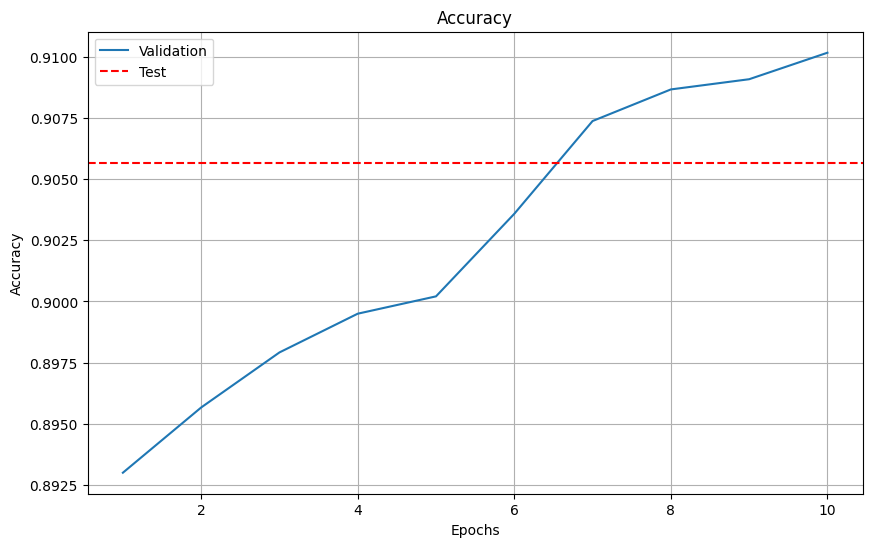

Final validation accuracy: 0.9057
Final Test accuracy: 0.9057


In [28]:
import matplotlib.pyplot as plt

train_history = distilbert_trainer.state.log_history

eval_accuracies = [
    log["eval_accuracy"] for log in train_history if "eval_accuracy" in log
]


epochs = range(1, DISTILBERT_EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, eval_accuracies[:-1], label="Validation")  # 마지막 값은 테스트 정확도
plt.axhline(y=test_accuracy, color="r", linestyle="--", label="Test")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final validation accuracy: {eval_accuracies[-2]:.4f}")
print(f"Final Test accuracy: {test_accuracy:.4f}")

## OpenAI GPT 모델 기반의 분류 모델 정의하기

In [31]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# 토크나이저와 모델 로드
gpt_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
classifier_g = GPT2ForSequenceClassification.from_pretrained(
    "openai-community/gpt2",
    num_labels=NUM_AG_NEWS_LABELS,
    id2label=ag_news_id2label,
    label2id=ag_news_label2id,
)

# GPT-2 토크나이저에는 기본적으로 패딩 토큰이 없으므로 추가
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
classifier_g.config.pad_token_id = classifier_g.config.eos_token_id

# GPT-2 모델의 모든 레이어들을 freeze
for param in classifier_g.transformer.parameters():
    param.requires_grad = False


# 데이터셋에 전처리 적용
def preprocess_function(examples):
    return gpt_tokenizer(examples["text"])


gpt_tokenized_dataset = ds_ag_news.map(preprocess_function, batched=True)

# 데이터셋 분리
gpt_ds_split = gpt_tokenized_dataset["train"].train_test_split(test_size=0.2)
gpt_train_dataset = gpt_ds_split["train"]
gpt_val_dataset = gpt_ds_split["test"]

# TrainingArguments 설정
GPT_DIR_OUTPUT = "../data/new_classifier_from_gpt"
GPT_DIR_LOGGING = f"{GPT_DIR_OUTPUT}/logs"
GPT_EPOCHS = 10
GPT_LEARNING_RATE = 1e-3
GPT_BATCH_SIZE = 64
GPT_WEIGHT_DECAY = 0.0

gpt_training_args = TrainingArguments(
    output_dir=GPT_DIR_OUTPUT,
    num_train_epochs=GPT_EPOCHS,
    per_device_train_batch_size=GPT_BATCH_SIZE,
    per_device_eval_batch_size=GPT_BATCH_SIZE,
    weight_decay=GPT_WEIGHT_DECAY,
    learning_rate=GPT_LEARNING_RATE,
    logging_dir=GPT_DIR_LOGGING,
    logging_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Trainer 초기화
gpt_trainer = Trainer(
    model=classifier_g,
    args=gpt_training_args,
    train_dataset=gpt_train_dataset,
    eval_dataset=gpt_val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=gpt_tokenizer,
)

/Users/joyuiyeong/.pyenv/versions/3.11.9/envs/deeplearning/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [32]:
gpt_trainer.train()

  0%|          | 0/15000 [00:00<?, ?it/s]

{'loss': 0.3857, 'grad_norm': 13.47107982635498, 'learning_rate': 0.0009000000000000001, 'epoch': 1.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.27930518984794617, 'eval_accuracy': 0.899125, 'eval_runtime': 153.1049, 'eval_samples_per_second': 156.755, 'eval_steps_per_second': 2.449, 'epoch': 1.0}
{'loss': 0.293, 'grad_norm': 6.807064056396484, 'learning_rate': 0.0008, 'epoch': 2.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.27037370204925537, 'eval_accuracy': 0.905875, 'eval_runtime': 150.3481, 'eval_samples_per_second': 159.63, 'eval_steps_per_second': 2.494, 'epoch': 2.0}
{'loss': 0.2847, 'grad_norm': 6.577025413513184, 'learning_rate': 0.0007, 'epoch': 3.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.27178502082824707, 'eval_accuracy': 0.9027916666666667, 'eval_runtime': 145.289, 'eval_samples_per_second': 165.188, 'eval_steps_per_second': 2.581, 'epoch': 3.0}
{'loss': 0.282, 'grad_norm': 2.4643468856811523, 'learning_rate': 0.0006, 'epoch': 4.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.26102128624916077, 'eval_accuracy': 0.9065416666666667, 'eval_runtime': 146.7524, 'eval_samples_per_second': 163.541, 'eval_steps_per_second': 2.555, 'epoch': 4.0}
{'loss': 0.2787, 'grad_norm': 16.357824325561523, 'learning_rate': 0.0005, 'epoch': 5.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.26358041167259216, 'eval_accuracy': 0.9050416666666666, 'eval_runtime': 138.2148, 'eval_samples_per_second': 173.643, 'eval_steps_per_second': 2.713, 'epoch': 5.0}
{'loss': 0.2752, 'grad_norm': 5.146598815917969, 'learning_rate': 0.0004, 'epoch': 6.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.2665274143218994, 'eval_accuracy': 0.904375, 'eval_runtime': 159.4517, 'eval_samples_per_second': 150.516, 'eval_steps_per_second': 2.352, 'epoch': 6.0}
{'loss': 0.274, 'grad_norm': 4.5207109451293945, 'learning_rate': 0.0003, 'epoch': 7.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.2612842619419098, 'eval_accuracy': 0.9082916666666667, 'eval_runtime': 149.2198, 'eval_samples_per_second': 160.837, 'eval_steps_per_second': 2.513, 'epoch': 7.0}
{'loss': 0.2697, 'grad_norm': 12.62037467956543, 'learning_rate': 0.0002, 'epoch': 8.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.25581714510917664, 'eval_accuracy': 0.9073333333333333, 'eval_runtime': 148.8663, 'eval_samples_per_second': 161.218, 'eval_steps_per_second': 2.519, 'epoch': 8.0}
{'loss': 0.2671, 'grad_norm': 14.353818893432617, 'learning_rate': 0.0001, 'epoch': 9.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.2532919645309448, 'eval_accuracy': 0.910375, 'eval_runtime': 142.5339, 'eval_samples_per_second': 168.381, 'eval_steps_per_second': 2.631, 'epoch': 9.0}
{'loss': 0.2649, 'grad_norm': 7.680771350860596, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.2527273893356323, 'eval_accuracy': 0.9094166666666667, 'eval_runtime': 146.4377, 'eval_samples_per_second': 163.892, 'eval_steps_per_second': 2.561, 'epoch': 10.0}
{'train_runtime': 8237.3034, 'train_samples_per_second': 116.543, 'train_steps_per_second': 1.821, 'train_loss': 0.28749833374023437, 'epoch': 10.0}


TrainOutput(global_step=15000, training_loss=0.28749833374023437, metrics={'train_runtime': 8237.3034, 'train_samples_per_second': 116.543, 'train_steps_per_second': 1.821, 'total_flos': 6.447424308550042e+16, 'train_loss': 0.28749833374023437, 'epoch': 10.0})

In [33]:
gpt_test_results = gpt_trainer.evaluate(gpt_tokenized_dataset["test"])
gpt_test_results

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.26194849610328674,
 'eval_accuracy': 0.9069736842105263,
 'eval_runtime': 69.0031,
 'eval_samples_per_second': 110.14,
 'eval_steps_per_second': 1.725,
 'epoch': 10.0}

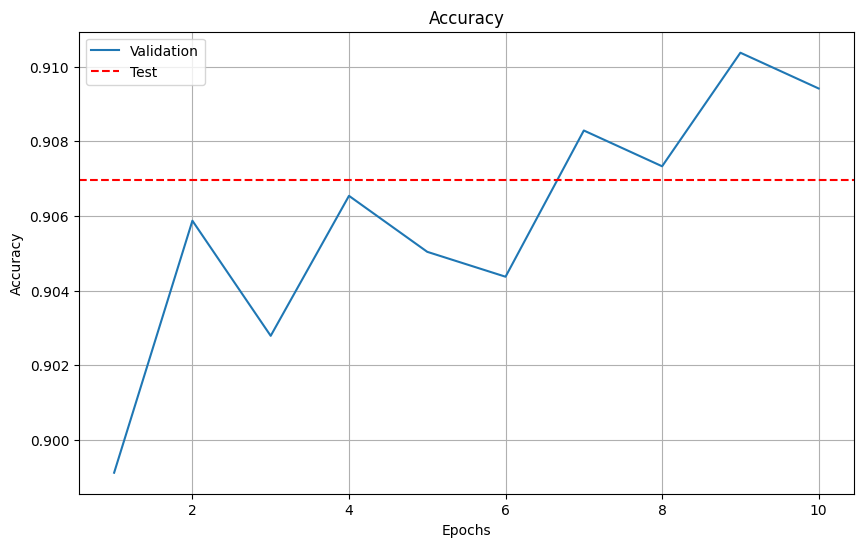

Final validation accuracy: 0.9094
Final Test accuracy: 0.9070


In [34]:
gpt_test_accuracy = gpt_test_results["eval_accuracy"]
gpt_train_history = gpt_trainer.state.log_history

gpt_eval_accuracies = [
    log["eval_accuracy"] for log in gpt_train_history if "eval_accuracy" in log
]


epochs = range(1, DISTILBERT_EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(
    epochs, gpt_eval_accuracies[:-1], label="Validation"
)  # 마지막 값은 테스트 정확도
plt.axhline(y=gpt_test_accuracy, color="r", linestyle="--", label="Test")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final validation accuracy: {gpt_eval_accuracies[-2]:.4f}")
print(f"Final Test accuracy: {gpt_test_accuracy:.4f}")